Same as the randomisation notebook. 

In [1]:
require(compiler)
require(hdf5r)

Loading required package: compiler
Loading required package: hdf5r
Warning message:
"package 'hdf5r' was built under R version 3.6.3"

In [2]:
# LOAD THE FIRST POPULATION. 2013 HDF5
dat1<-H5File$new('2013_X_int_10.hdf5', 'r')
# LOAD THE SECOND POPULATION. 2015 HDF5
dat2<-H5File$new('2015_X_int_10.hdf5', 'r')
# maf>=0.1 FOR THE FIRST TEMPORAL SAMPLE, NO REQUIREMENT FOR THE SECOND

In [3]:
dat1
dat2

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2013_X_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type  dataset.dims dataset.type_class
      POS H5I_DATASET          4677        H5T_INTEGER
 genotype H5I_DATASET 2 x 73 x 4677        H5T_INTEGER

Class: H5File
Filename: C:\Users\isabe\OneDrive - Imperial College London\Final Year Project\2015_X_int_10.hdf5
Access type: H5F_ACC_RDONLY
Listing:
     name    obj_type   dataset.dims dataset.type_class
      POS H5I_DATASET           4677        H5T_INTEGER
 genotype H5I_DATASET 2 x 104 x 4677        H5T_INTEGER

In [4]:
# READ genotype AS R ARRAY, 3D
genotype1<-dat1[['genotype']][,,]
dim(genotype1)
unique(as.numeric(genotype1))
# DO THE SAME FOR 2015 HDF5
genotype2<-dat2[['genotype']][,,]
dim(genotype2)
unique(as.numeric(genotype2))

[1]    2   73 4677

[1] 0 1 2 3

[1]    2  104 4677

[1] 0 1 2 3

In [5]:
POS<-dat1[['POS']][]

In [6]:
# FUNCTION TO RETURN THE FOUR ALLELE COUNTS. PER LOCUS
allele.count<-function(GT)
{
    a1<-GT[1,]
    a2<-GT[2,]
    a<-c(a1, a2)
    return(c(sum(a=='0'), sum(a=='1'), sum(a=='2'), sum(a=='3')))
}

# FUNCTION TO RETURN NUMBER OF ALLELES. PER LOCUS
allelism<-function(allele_count)
{
    return(sum(allele_count>0))
}

# FUNCTION TO CONVERT COUNT TO FREQUENCY, PER LOCUS
allele.frequency<-function(allele_count)
{
    y<-allele_count[1]+allele_count[2]+allele_count[3]+allele_count[4]
    return(allele_count/y)
}

# FUNCTION TO RETURN WHICH LARGEST FREQ? PER LOCUS
# 1 RETURN THE LARGEST, 2 RETURN MAF, ETC
cal.frequency<-function(allele_frequency, which=1)
{
    return(allele_frequency[order(allele_frequency, decreasing=T)[which]])
}

# FUNCTION TO RETURN THE WHICH LARGEST ALLELE (0, 1, 2, 3?) PER LOCUS
# 1 RETURN THE LARGEST
find.allele<-function(allele_count, which=1)
{
    return(order(allele_count, decreasing=T)[which]-1)
}

# FUNCTION TO CONVERT MULTIALLELIC LOCI INTO BIALLELIC (GROUP REMAINING THREE AS ALT)
# RETURN NUMERIC. 0 (REF HOMOZYGOTE), 1 (HETEROZYGOTE), 2, MISSING IS NA
to.biallelic<-function(GT, ref='0')
{
    a1<-GT[1,]
    a2<-GT[2,]
    b1<-1-(a1==ref)
    b2<-1-(a2==ref)
    return(b1+b2)
}

In [7]:
# FIND ALLELE COUNT
allele_count1<-t(apply(genotype1, 3, allele.count))
dim(allele_count1)
allele_count1[1,]
# TO ALLELE FREQ
af1<-t(apply(allele_count1, 1, allele.frequency))
dim(af1)
af1[1,]
# FIND MAJOR ALeLE FREQ AND ITS SUMMARY
major_f1<-apply(af1, 1, cal.frequency, which=1)
length(major_f1)
# FIND THE MAJOR ALLELE 
major_allele1<-apply(allele_count1, 1, find.allele, which=1)

[1] 4677    4

[1]  32 114   0   0

[1] 4677    4

[1] 0.2191781 0.7808219 0.0000000 0.0000000

[1] 4677

In [8]:
# CONVERT TO GENOTYPE MATRIX (WITH 0, 1, 2 ONLY, 0 IS THE MAJOR ALLELE)
g1<-matrix(nc=dim(genotype1)[2], nr=dim(genotype1)[3])
g2<-matrix(nc=dim(genotype2)[2], nr=dim(genotype2)[3])
for (i in 1:nrow(g1))
{
    g1[i,]<-to.biallelic(genotype1[,,i], ref=major_allele1[i])
    g2[i,]<-to.biallelic(genotype2[,,i], ref=major_allele1[i])
}
dim(g1)
dim(g2)
unique(as.numeric(g1))
unique(as.numeric(g2))

[1] 4677   73

[1] 4677  104

[1] 1 0 2

[1] 1 0 2

In [9]:
# THE TWO SAMPLE SIZES
s1<-ncol(g1)
s2<-ncol(g2)
s1
s2
# NUMBER OF LOCI 
K<-nrow(g1)
K

[1] 73

[1] 104

[1] 4677

In [10]:
# RECALCULATE THE TWO ALLELE FREQ AGAIN
f1<-apply(g1, 1, sum)/(2*s1)
f2<-apply(g2, 1, sum)/(2*s2)

# TEMPORAL F (WHICH VERSION?)
F<-mean((f1-f2)^2)/mean(f1*(1-f1))
F

# SIZE OF SAMPLING ERROR 
0.5/s1+0.5/s2

# MINUS SAMPLING ERROR
F-0.5/s1-0.5/s2

[1] 0.0119132

[1] 0.01165701

[1] 0.0002561925

In [11]:
# Ne ESTIMATE, 20 GENERATIONS APART?
t<-20
N<-t/(2*(F-0.5/s1-0.5/s2))
N

[1] 39033.15

In [12]:
# EXPLICITLY TELL R THAT g1 IS A MATRIX OF INTEGERS
mode(g1)<-'integer'
# CALCULATE R MATRIX AND EIGENVALUES FOR Fa
# ONLY CHANGE THE 39033 TO YOUR Ne ESTIMATE. IF THE ESTIMATE IS NEGATIVE, JUST SAY 1e6 (ONE MILLION)
dyn.load('../cpp/r_matrix.dll')
R <- .Call('cal_corr_matrix_unphased', t(g1), as.integer(POS), 0.016, 
           as.integer(39033), 
           as.integer(s1), as.integer(s2), as.integer(t), 4)
dyn.unload('../cpp/r_matrix.dll')
e <- eigen(R, only.values=TRUE)
gc()

Using 40 cores. 


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,716063,38.3,1358172,72.6,1098477,58.7
Vcells,24717699,188.6,109396317,834.7,134292537,1024.6


In [13]:
# C.I. WITH Fa
gen_Q2 <- function(eigenvalues)
{
  working_eigenvalues <- eigenvalues[eigenvalues>0]
  working_eigenvalues <- working_eigenvalues*sum(eigenvalues)/sum(working_eigenvalues)
  dyn.load('../cpp/r_matrix.dll')
  y <- .Call('generate_Q2', working_eigenvalues, 50000)
  dyn.unload('../cpp/r_matrix.dll')
  return(y)
}
# EMPIRICAL Q2 DISTRIBUTION. YOU WILL GET A SLIGHTLY DIFFERENT Q2 BECAUSE OF RANDOMNESS
Q2<-gen_Q2(e$values)

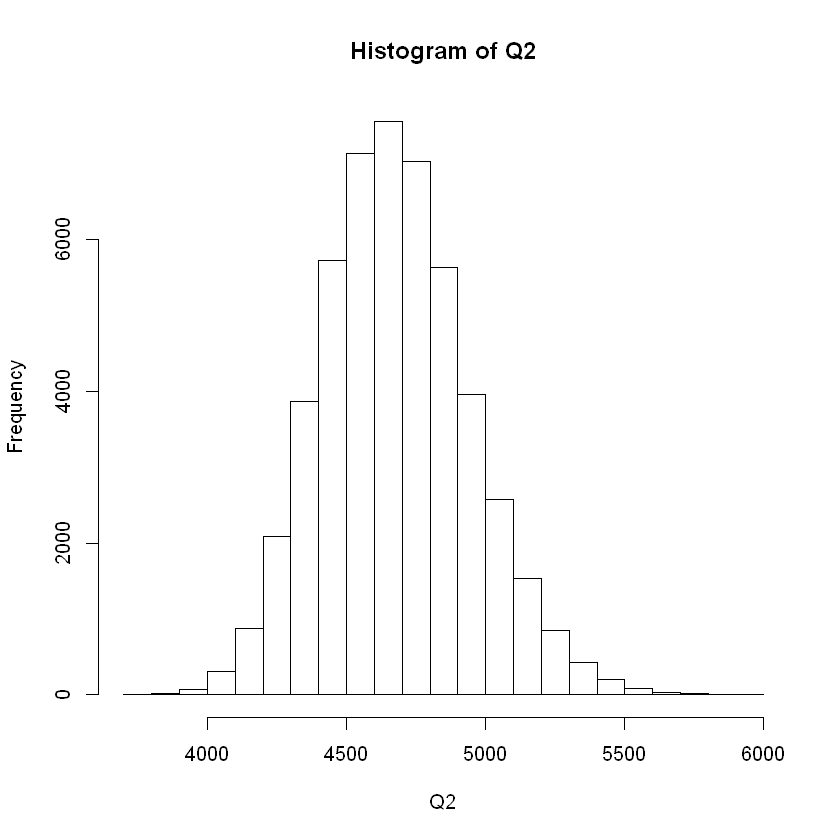

In [14]:
hist(Q2)

In [15]:
# LOWER CI FOR F
F_lower<-K*F/quantile(Q2, 0.975)
# UPPER CI FOR F
F_upper<-K*F/quantile(Q2, 0.025)
c(F_lower, F, F_upper)

97.5%                  2.5% 
0.01063959 0.01191320 0.01326728

In [17]:
# LOWER CI FOR Ne, FROM THE UPPER CI F
N_lower<-t/(2*(F_upper-0.5/s1-0.5/s2))
N_lower

N_upper<-t/(2*(F_lower-0.5/s1-0.5/s2))
N_upper

2.5% 
6210.135

97.5% 
-9828.763

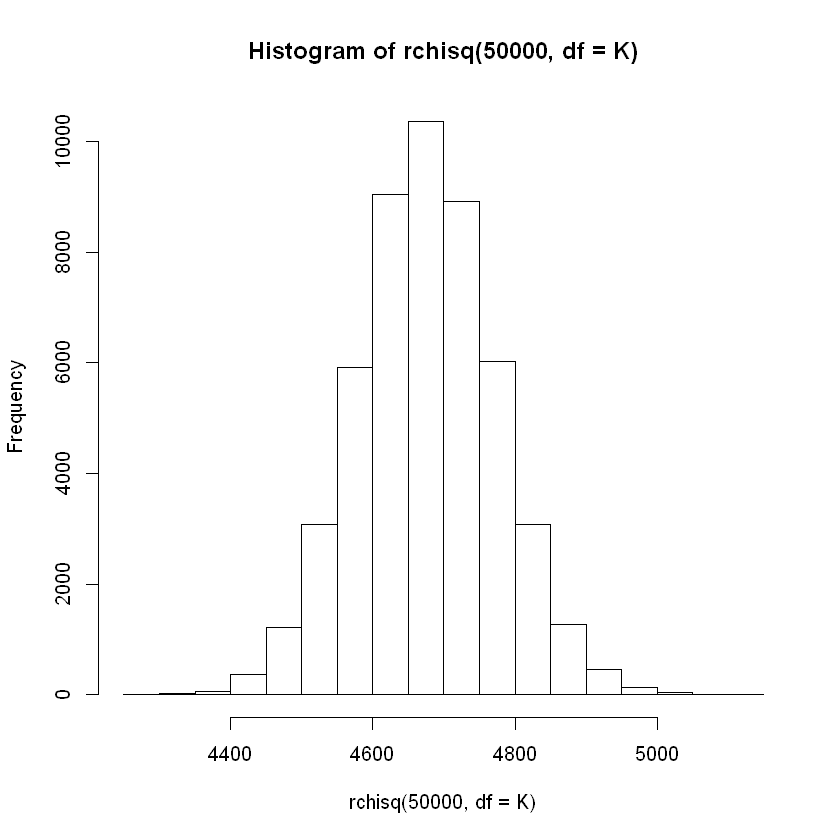

In [18]:
# COMPARISON, CHI-SQUARE WITH K DEGREES OF FREEDOM
# IT IS MUCH NARROWER THAN THE ONE ABOVE
hist(rchisq(50000, df=K))